In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on graph (the Graph DGMRF model) on the Wikipedia example

The original article is [here](https://proceedings.mlr.press/v162/oskarsson22a/oskarsson22a.pdf) and the code can be found [here](https://github.com/joeloskarsson/graph-dgmrf/blob/main/utils.py).

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""

from functools import partial
import jax
#jax.config.update('jax_platforms', "cpu")
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

2024-06-28 13:27:09.799425: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## Load the wikipedia graph data

In [4]:
edges_mat = np.genfromtxt("./chameleon_edges.csv", delimiter=",", skip_header=1).astype(np.int32)
y = np.log(np.genfromtxt("./chameleon_target.csv", delimiter=",", skip_header=1) + 1e-6)[:, 1] # take log as in the original code (https://github.com/joeloskarsson/graph-dgmrf/blob/main/data_loading/wiki.py#L31)

N = y.shape[0]

**Note that it would be good to preprocess data: e.g. isolated nodes** (see [original code](https://github.com/joeloskarsson/graph-dgmrf/blob/4c640b3eba025fdfdec8db977ca0f484748737d1/data_loading/wiki.py#L41))

Convert the edge list to adjacency matrix

In [5]:
def update_adjacency_matrix(adjacency_matrix, edge):
    i, j = edge
    adjacency_matrix = adjacency_matrix.at[i, j].set(1)
    adjacency_matrix = adjacency_matrix.at[j, i].set(1)
    return adjacency_matrix, None

def edge_list_to_adjacency_matrix(edge_list, num_nodes):
    edge_array = jnp.array(edge_list)
    adjacency_matrix = jnp.zeros((num_nodes, num_nodes), dtype=jnp.int8)
    adjacency_matrix, _ = jax.lax.scan(update_adjacency_matrix, adjacency_matrix, edge_array)

    return adjacency_matrix

In [6]:
with jax.default_device(cpu_device):
    A = edge_list_to_adjacency_matrix(edges_mat, y.shape[0])
try:
    A = jax.device_put(A, gpu_device)
except NameError:
    pass

Compute the diagonal of the degree matrix

In [7]:
D = jnp.sum(A, axis=1).astype(jnp.int32)

As stated in the article, 50% of nodes will be unobserved, randomly and uniformly chosen

In [8]:
mask = jnp.zeros_like(y)
key, subkey = jax.random.split(key, 2)
idx_unobserved = jax.random.choice(subkey, jnp.arange(y.shape[0]), shape=(y.shape[0] // 100,), replace=False)
mask = mask.at[idx_unobserved].set(1)
y = jnp.where(mask == 0, y, 0)

Optionally add noise

In [9]:
true_sigma_noise = 0.0001
key, subkey = jax.random.split(key, 2)
y = y + jax.random.normal(subkey, y.shape) * true_sigma_noise

In [10]:
D

Array([  5,  46,  20, ...,  10,  41, 116], dtype=int32)

## Define the DGMRF components

In [11]:
from dgmrf.models import DGMRF, MeanField, FactorizedS
from dgmrf.utils import get_adjacency_matrix_lattice

**Similarly to the notebook presenting the graph DGMRF for a regular lattice, convergence problems happened for $L>2$**

In [12]:
L = 2
Nq = 10

In [13]:
y = y.flatten()
mask = mask.flatten()

In [14]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(
    subkey,
    L,
    A_D=(A, D),
    log_det_method="eigenvalues",
    with_bias=True,
    non_linear=False,
)


Instanciate the variational distribution

In [15]:
key, subkey1, subkey2 = jax.random.split(key, 3)

q_phi = MeanField(N=N, key=subkey1)
# q_phi = FactorizedS(
#     N=N,
#     dgmrf_args=(subkey1, 1),
#     dgmrf_kwargs= {
#         "A_D":(A, D),
#         "log_det_method":"eigenvalues"
#     },
#     key=subkey2
# )

Define the Model equinox module `(DGMRF, VariationalDistribution, noise_parameter_array)`. This is just a container-like structure

In [16]:
from dgmrf.train import Model
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))

## Variational inference to compute model parameters

In [17]:
n_iter = 50000
lr_graph = 1e-3

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0), 'q_phi': optax.adam(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [18]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

print_rate = 5000
key, subkey = jax.random.split(key, 2)
model, loss_val, opt_state = train_loop(dgmrf_elbo, model, y, n_iter, tx, opt_state, subkey, print_rate, N, Nq, mask=mask)

Iteration 0, loss_value = 4628276224.0
Iteration 5000, loss_value = 764840256.0
Iteration 10000, loss_value = 71636960.0
Iteration 15000, loss_value = 2654562.5
Iteration 20000, loss_value = 295727.21875
Iteration 25000, loss_value = 5616.9541015625
Iteration 30000, loss_value = 172.94485473632812
Iteration 35000, loss_value = 9.949222564697266
Iteration 40000, loss_value = -8.548714637756348
Iteration 45000, loss_value = -10.796442985534668


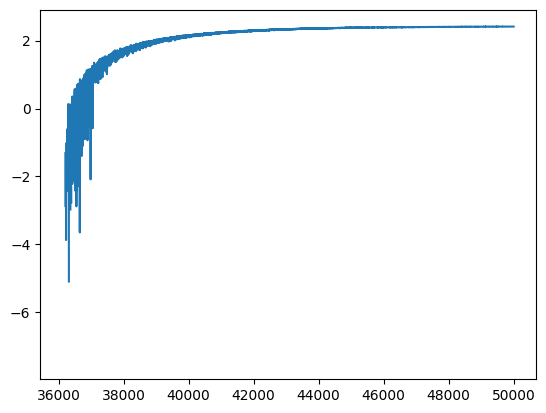

In [19]:
plt.plot(jnp.log(loss_val))
plt.show()

The means of the variational distribution will be the inferred values as a first approximation

In [20]:
rmse_nu_phi = jnp.sqrt(jnp.mean((model.posterior.params["nu"] - y) ** 2))
print("RMSE with the means of the variational distribution", rmse_nu_phi)

RMSE with the means of the variational distribution 1.1361549


**This is even better than the score reported in Table 1 of the article. We thus seem able to reasonably infer the unobserved node attributes**